In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns
from seaborn import distplot
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from random import randint
import dask.dataframe as dd

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV

from sklearn.linear_model import *
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Stage 3: Exploratory Data Analysis and Statistical Modelling

In this stage, I performed exploratory data analysis to get an idea of how my data could be analyzed in order to answer my research question, and get an idea of whether any further data manipulation was needed to achieve my goals. 

In [2]:
bts_data = pd.read_csv('data/bts_data_cleaned.csv')
bp_data = pd.read_csv('data/bp_data_cleaned.csv')
exo_data = pd.read_csv('data/exo_data_cleaned.csv')
shinee_data = pd.read_csv('data/shinee_data_cleaned.csv')
rv_data = pd.read_csv('data/rv_data_cleaned.csv')
twice_data = pd.read_csv('data/twice_data_cleaned.csv')

In [3]:
data = pd.concat([bts_data, bp_data, exo_data, shinee_data, rv_data, twice_data], axis=0, ignore_index=True)

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
clean_data = data.copy()

A glimpse of the cleaned data:

In [7]:
clean_data.head()

,album,release_date,track_number,name,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,artist
0,MAP OF THE SOUL : 7 ~ THE JOURNEY ~,2020-07-14,1,INTRO : Calling,0.582000,0.486,0.610,0.791,0.144,-12.063,0.0348,144.992,0.0806,66,bts
1,MAP OF THE SOUL : 7 ~ THE JOURNEY ~,2020-07-14,3,Boy With Luv - Japanese ver.,0.066100,0.673,0.855,0.000,0.209,-4.650,0.0890,119.917,0.7800,64,bts
2,MAP OF THE SOUL : 7 ~ THE JOURNEY ~,2020-07-14,4,Make It Right - Japanese ver.,0.016300,0.571,0.703,0.000,0.262,-7.401,0.4680,104.067,0.2380,65,bts
3,MAP OF THE SOUL : 7 ~ THE JOURNEY ~,2020-07-14,5,Dionysus - Japanese ver.,0.021800,0.455,0.893,0.000,0.358,-3.712,0.1480,175.992,0.5880,66,bts
4,MAP OF THE SOUL : 7 ~ THE JOURNEY ~,2020-07-14,6,IDOL - Japanese ver.,0.000331,0.705,0.754,0.000,0.129,-5.453,0.0895,126.014,0.4220,62,bts


In [7]:
for label, row in clean_data.iterrows():
    if (clean_data.loc[label, 'track_number'] == 1):
        clean_data.loc[label, 'main_track'] = 1
    else:
        clean_data.loc[label, 'main_track'] = 0
    clean_data.loc[label, 'release_year'] = int(clean_data.loc[label, 'release_date'][:4])

By looking at the data, and combining what I already knew about the k-pop industry, I realized that many of the most popular songs of artists were the main tracks of the albums. Those tracks were more frequently promoted than other songs of the same album by the same artist. Thus, I created an indicator variable that indicated whether a particular track was the main track of the album or not. I also extracted the year of the release date.

In [8]:
for label, row in clean_data.iterrows():
    if (clean_data.loc[label, 'popularity'] < 25):
        clean_data.loc[label, 'pop_target'] = 'low'
    elif (clean_data.loc[label, 'popularity'] < 50):
        clean_data.loc[label, 'pop_target'] = 'medium'
    elif (clean_data.loc[label, 'popularity'] < 75):
        clean_data.loc[label, 'pop_target'] = 'high'
    else:
        clean_data.loc[label, 'pop_target'] = 'very high'

I created a categorical variable called "pop_target", which represents the category that a song's popularity was in. 

In [10]:
corrMatrix = clean_data[['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'loudness', 'speechiness', 
                  'tempo', 'valence', 'popularity', 'main_track']].corr()

In [11]:
print(corrMatrix)

                  acousticness  danceability    energy  instrumentalness  \
acousticness          1.000000     -0.208019 -0.617619         -0.048268   
danceability         -0.208019      1.000000  0.182833         -0.006885   
energy               -0.617619      0.182833  1.000000         -0.093962   
instrumentalness     -0.048268     -0.006885 -0.093962          1.000000   
liveness             -0.044377     -0.061212  0.179470         -0.030416   
loudness             -0.423119      0.185907  0.699233         -0.295314   
speechiness          -0.070649     -0.103194  0.234972         -0.030425   
tempo                -0.084291     -0.169613  0.097157          0.036726   
valence              -0.244287      0.427089  0.427194         -0.100190   
popularity           -0.046631      0.028283 -0.033442         -0.129939   
main_track            0.015275      0.066628  0.029534         -0.013462   

                  liveness  loudness  speechiness     tempo   valence  \
acousticness  

Above is a correlation matrix that includes the correlation between any two factors.

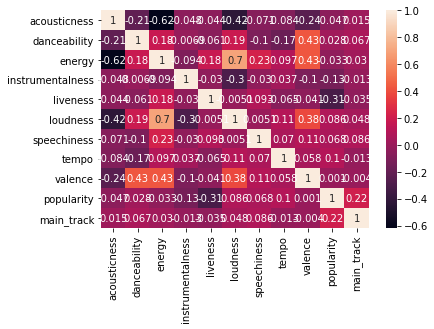

In [12]:
sns.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (14,7)
sns.set_context("poster",font_scale=.5)
plt.show()

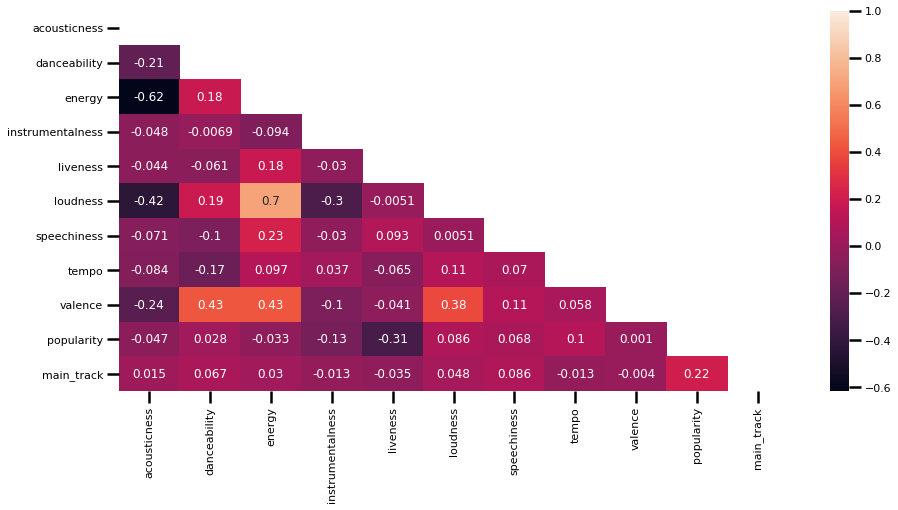

In [13]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(corrMatrix, mask=mask, annot=True)
plt.rcParams["figure.figsize"] = (13,7)
sns.set_context("poster",font_scale=0.7)
plt.show()

Here, I modified the visualization of the correlation matrix for convenience. 
### Findings:
Energy and loudness, valence and danceability, valence and energy are moderately correlated.
main_track and popularity is stronger in correlation (than other variables with popularity). 

## Visualizing Trends in the Data:

In [14]:
plt.figure(figsize=(12, 6))
bts_df = clean_data[clean_data.artist == 'bts']
bp_df = clean_data[clean_data.artist == 'bp']
rv_df = clean_data[clean_data.artist == 'red velvet']
shinee_df = clean_data[clean_data.artist == 'shinee']
exo_df = clean_data[clean_data.artist == 'exo']
twice_df = clean_data[clean_data.artist == 'twice']

<Figure size 864x432 with 0 Axes>

In [15]:
data_2013 = clean_data[clean_data['release_year'] > 2012]

by_year = data_2013.groupby(['artist', 'release_year']).agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 
                                    'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean', 
                                             'tempo': 'mean', 'loudness': 'mean'})
bts_agg = by_year.iloc[5:13]
exo_agg = by_year.iloc[13:21]

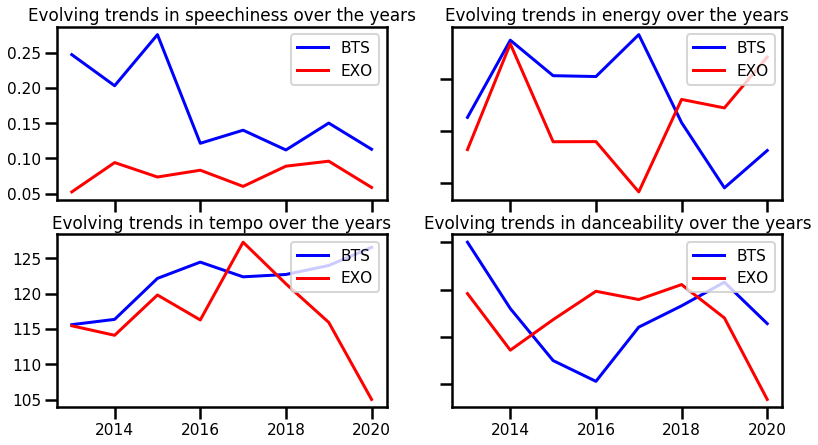

In [16]:
fig, axs = plt.subplots(2,2)
axs[0, 0].plot(list(range(2013, 2021)), bts_agg['speechiness'], label='BTS', color='blue', linestyle='solid')
axs[0, 0].plot(list(range(2013, 2021)), exo_agg['speechiness'], label='EXO', color='red', linestyle='solid')
ax.set(xlabel='Released year', ylabel='Speechiness')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_title('Evolving trends in speechiness over the years')

axs[0, 1].plot(list(range(2013, 2021)), bts_agg['energy'], label='BTS', color='blue', linestyle='solid')
axs[0, 1].plot(list(range(2013, 2021)), exo_agg['energy'], label='EXO', color='red', linestyle='solid')
ax.set(xlabel='Released year', ylabel='Energy')
axs[0, 1].legend(loc='upper right')
axs[0, 1].set_title('Evolving trends in energy over the years')

axs[1, 0].plot(list(range(2013, 2021)), bts_agg['tempo'], label='BTS', color='blue', linestyle='solid')
axs[1, 0].plot(list(range(2013, 2021)), exo_agg['tempo'], label='EXO', color='red', linestyle='solid')
ax.set(xlabel='Released year', ylabel='Tempo')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_title('Evolving trends in tempo over the years')

axs[1, 1].plot(list(range(2013, 2021)), bts_agg['danceability'], label='BTS', color='blue', linestyle='solid')
axs[1, 1].plot(list(range(2013, 2021)), exo_agg['danceability'], label='EXO', color='red', linestyle='solid')
ax.set(xlabel='Released year', ylabel='danceability')
axs[1, 1].legend(loc='upper right')
axs[1, 1].set_title('Evolving trends in danceability over the years')

for ax in axs.flat:
    ax.label_outer()

Here, I have compared the trends of BTS and EXO music data of a few of the musical factors and visualized the results. The first significant finding is that ooverall, BTS's songs had much, much more words (high speechiness) than EXO's songs for all years. Another finding that was interesting was that BTS's songs had more energy until 2017, but the songs started to drop in energy after 2017, while EXO's songs started to become more energized.

## Summary of Stage 3:
- In this stage, I performed some exploratory data analysis in order to get more ideas about what I could possibly do to answer my research question.
- I looked at the correlation between any two factors in my dataset
- I also visualized a few trends of two groups (BTS and EXO)
- Overall, I felt this stage helped me better understand my dataset

## Stage 4: Use of Statistical Methods
#### Implementing logistic regression model

In [220]:
# adding a categorical label to popularity
for label, row in clean_data.iterrows():
    if (clean_data.loc[label, 'popularity'] < 50):
        clean_data.loc[label, 'pop_target'] = 'low'
    else:
        clean_data.loc[label, 'pop_target'] = 'high'


In [221]:
X = clean_data[['tempo', 'energy', 'acousticness', 'liveness', 
                'speechiness', 'main_track', 'instrumentalness']].to_numpy()
y = clean_data['pop_target'].values

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [224]:
type(X_train)

numpy.ndarray

In [225]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test) 

In [226]:
classifier = LogisticRegression(random_state = 0) 
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [232]:
predictions = classifier.predict(X_test) 

In [230]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [234]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.66      0.34      0.45        61
         low       0.76      0.92      0.83       139

    accuracy                           0.74       200
   macro avg       0.71      0.63      0.64       200
weighted avg       0.73      0.74      0.72       200



- Accuracy is 0.74, slightly better than the KNN model (highest accuracy with k = 7 was only 0.62)

## Summary of Stage 4 so far: (still in progress)
- For this stage, I have built a logistic regression model after representing popularity as a binary indicator, but I have not yet summarized my results. 
## Next Steps:
- I will look at the results from these models and analyze them, and summarize some important results. This would help me come up with ways to improve my models and optimize the results. 